<a href="https://colab.research.google.com/github/AshishGusain17/via_google_colab/blob/master/images_only_untrained_tf_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 34173, done.
remote: Total 34173 (delta 0), reused 0 (delta 0), pack-reused 34173
Receiving objects: 100% (34173/34173), 512.42 MiB | 35.16 MiB/s, done.
Resolving deltas: 100% (21956/21956), done.
Checking out files: 100% (2497/2497), done.


In [2]:
!pip install --user Cython
!pip install --user contextlib2
!pip install --user pillow
!pip install --user lxml
!pip install --user jupyter
!pip install --user matplotlib

In [3]:
!python /content/models/research/setup.py build
!python /content/models/research/setup.py install

running build
running install
running bdist_egg
running egg_info
creating object_detection.egg-info
writing object_detection.egg-info/PKG-INFO
writing dependency_links to object_detection.egg-info/dependency_links.txt
writing requirements to object_detection.egg-info/requires.txt
writing top-level names to object_detection.egg-info/top_level.txt
writing manifest file 'object_detection.egg-info/SOURCES.txt'
reading manifest file 'object_detection.egg-info/SOURCES.txt'
writing manifest file 'object_detection.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying object_detection.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying object_detection.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying object_detection.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/e

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r --recursive '/content/drive/My Drive/colab_obj_detection/faster_rcnn_resnet101_coco_2018_01_28' '/content/models/research/object_detection'
!cp -r --recursive '/content/drive/My Drive/colab_obj_detection/training' '/content/models/research/object_detection'
!cp -r --recursive '/content/drive/My Drive/colab_obj_detection/images' '/content/models/research/object_detection'

In [13]:

%cd /content/models/research
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim
%cd object_detection/legacy
%cd ..
%cd ..
%cd ..
%cd ..
%cd ..

/content/models/research
env: PYTHONPATH=/content/models/research:/content/models/research/slim
/content/models/research/object_detection/legacy
/content/models/research/object_detection
/content/models/research
/content/models
/content
/


In [14]:
%ls

bin/                                       etc/    opt/    sys/
boot/                                      home/   proc/   tensorflow-1.15.2/
content/                                   lib/    root/   tmp/
datalab/                                   lib32/  run/    tools/
dev/                                       lib64/  sbin/   usr/
dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl  media/  srv/    var/
dlib-19.18.0-cp36-cp36m-linux_x86_64.whl   mnt/    swift/


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0125 09:04:14.466667 140486970365824 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0125 09:04:14.472239 140486970365824 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0125 09:04:14.472473 140486970365824 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:121: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instea

In [0]:
!pip install -U --pre tensorflow=="2.*"

In [17]:
!pip install pycocotools

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import os
import pathlib
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [0]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [0]:
PATH_TO_LABELS = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [53]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('/content/models/research/object_detection/test_images/image1.jpg'),
 PosixPath('/content/models/research/object_detection/test_images/image2.jpg'),
 PosixPath('/content/models/research/object_detection/test_images/image4.jpg'),
 PosixPath('/content/models/research/object_detection/test_images/image_car.jpg')]

In [44]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

76537856/76534733 [==============================] - 1s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [45]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [46]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [47]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

In [0]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [0]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

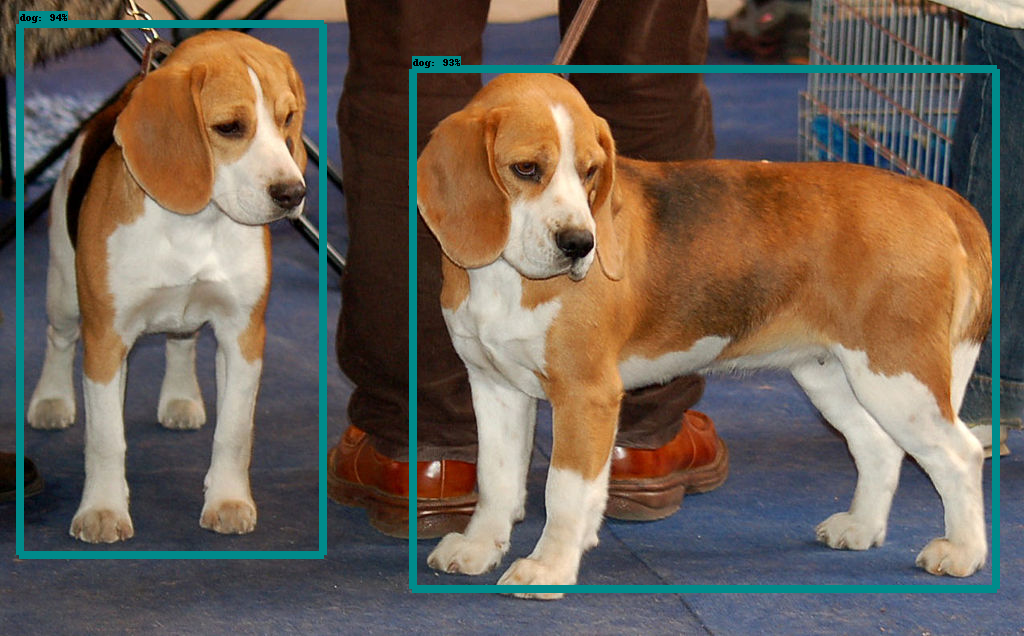

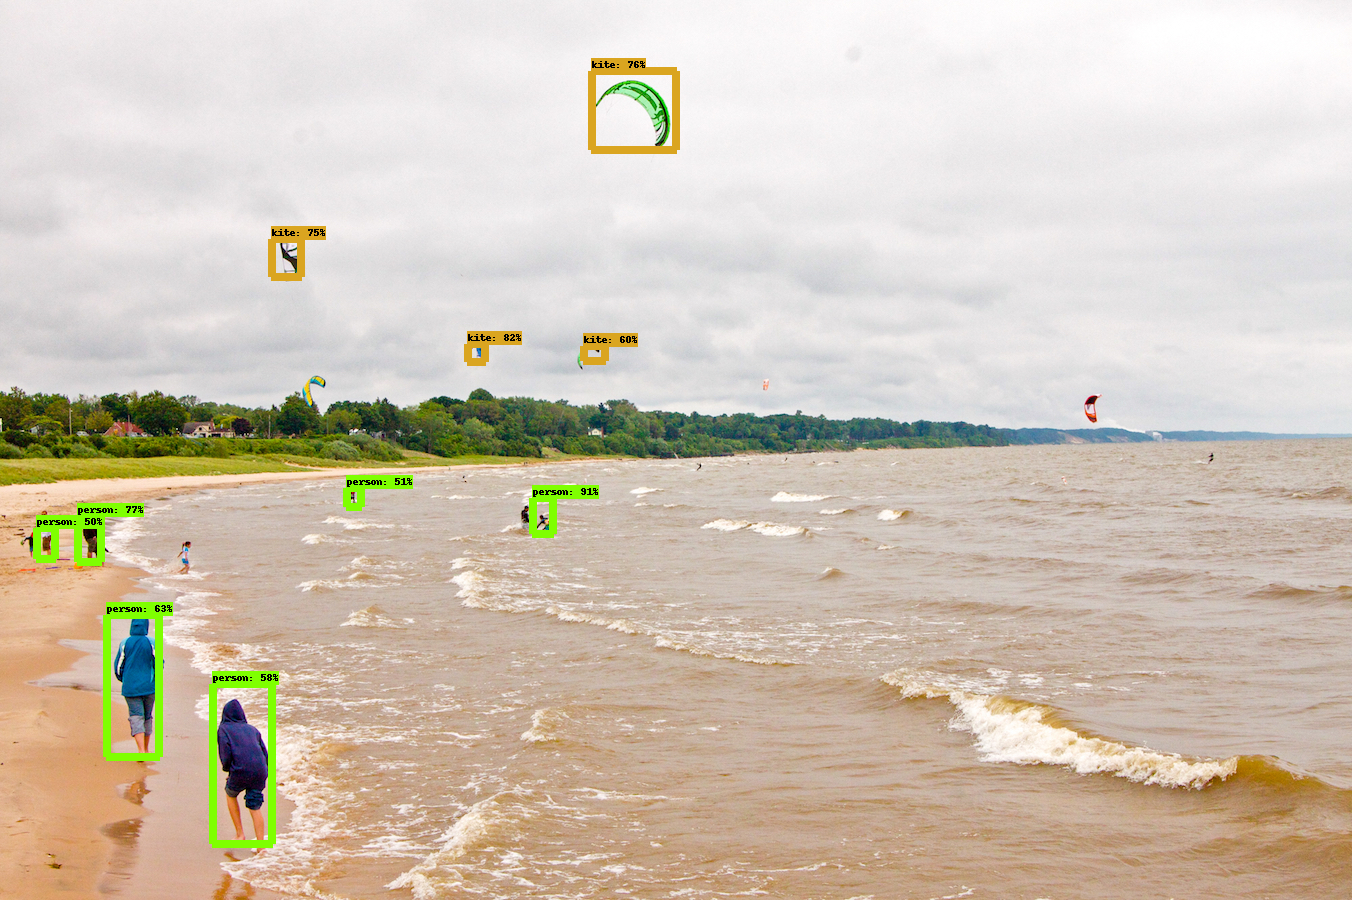

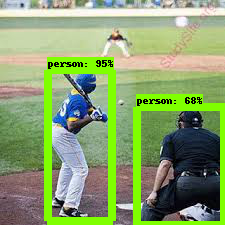

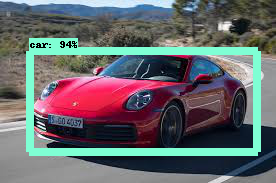

In [54]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)